In [ ]:
TRACKING_SERVER_HOST = "" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [ ]:
https://www.kaggle.com/datasets/unsdsn/world-happiness

In [33]:
numerical = ['standard_error', 'economy_gdp_per_capita', 'family',
       'health_life_expectancy', 'freedom', 'trust_government_corruption',
       'generosity', 'dystopia_residual']
categorical = ['country', 'region']
numerical+categorical

['standard_error',
 'economy_gdp_per_capita',
 'family',
 'health_life_expectancy',
 'freedom',
 'trust_government_corruption',
 'generosity',
 'dystopia_residual',
 'country',
 'region']

In [33]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

In [45]:
import pandas as  pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import xgboost as xgb



target = 'salary_in_usd'
numerical = ['remote_ratio']

categorical = ['work_year','experience_level','job_title','salary_currency','employee_residence','company_location','company_size']

def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)
    
def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)

def read(filename:str)->pd.DataFrame:
    "Load a parquet object from the file path, returning a DataFrame."
    df = pd.read_csv(f'../data/raw/{filename}')
    df.work_year = df.work_year.astype(str) 
    
    df['experience_level'] = df['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
        'MI': 'Mid/Intermediate level',
    })

    df['employment_type'] = df['employment_type'].replace({
        'FL': 'Freelancer',
        'CT': 'Contractor',
        'FT' : 'Full-time',
        'PT' : 'Part-time'
    })
    df['company_size'] = df['company_size'].replace({
        'S': 'SMALL',
        'M': 'MEDIUM',
        'L' : 'LARGE',
    })
    df['remote_ratio'] = df['remote_ratio'].astype(str)
    df['remote_ratio'] = df['remote_ratio'].replace({
        '0': 'On-Site',
        '50': 'Half-Remote',
        '100' : 'Full-Remote',
    })
    df['job_title'] = df['job_title'].apply(assign_broader_category)
    
    
    df = df[df[target]<250000]
    return df

def prepare(df:pd.DataFrame, fit: bool = False)->pd.DataFrame:
    "Prepare a raw dataframe, returning a prepare DataFrame"
    
    
    if fit:
        dv = DictVectorizer()
        scaler = RobustScaler().set_output(transform="pandas")
        df_scaled = scaler.fit_transform(df[numerical])
        
        dicts = df[categorical].to_dict(orient='records')
        dv = DictVectorizer()
        ohe = pd.DataFrame(dv.fit_transform(dicts).todense(), columns=dv.feature_names_)
         
        df_prepare = pd.concat([ohe,df_scaled,df[target]], axis=1)
        
        #dump_pickle(dv,'../data/preprocess/dv.pkl')
        #dump_pickle(scaler,'../data/preprocess/scaler.pkl')
        return df_prepare
        
    else:
        dv = load_pickle("../data/preprocess/dv.pkl")
        scaler = load_pickle("../data/preprocess/scaler.pkl")
        
        df_scaled = scaler.transform(df[numerical])
        
        dicts = df[categorical].to_dict(orient='records')
        ohe = pd.DataFrame(dv.transform(dicts).todense(), columns=dv.feature_names_)

        df_prepare = pd.concat([ohe,df_scaled,df[target]], axis=1)
        return df_prepare
    
    
def run(df_train:pd.DataFrame, df_test:pd.DataFrame,num_trials=100):
    
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)
    
    y_train = df_train[target].values
    y_test = df_test[target].values

    def objective(params):
        
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
        'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
        'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
        'objective': 'reg:linear',
        'seed': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )




In [46]:
raw_salaries = read('ds_salaries.csv')


In [38]:
raw_salaries.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [39]:
raw_salaries.shape

(3570, 11)

In [40]:
raw_salaries.sample(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2298,2022,Senior,Full-time,Data Science,205000,USD,205000,US,Full-Remote,US,MEDIUM
2787,2022,Senior,Full-time,Data Engineering,144000,USD,144000,US,Full-Remote,US,MEDIUM
470,2023,Mid/Intermediate level,Full-time,Data Engineering,75000,USD,75000,US,On-Site,US,MEDIUM
1489,2023,Senior,Full-time,Data Science,183500,USD,183500,US,Full-Remote,US,MEDIUM
1317,2023,Senior,Full-time,Data Science,216100,USD,216100,US,On-Site,US,MEDIUM


In [47]:
prepare_salaries = prepare(raw_salaries,fit=True).dropna()


<Axes: ylabel='Frequency'>

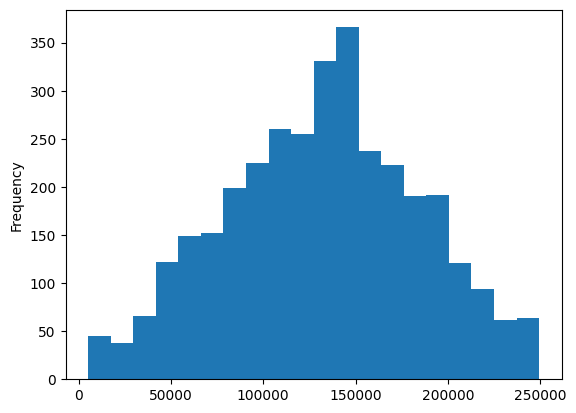

In [29]:
prepare_salaries[target].plot.hist(bins=20)

In [30]:
prepare_salaries[target].std()

52654.92159725733

In [48]:
run(prepare_salaries,prepare_salaries,10)

[23:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [159]:
train(prepare_data_2015,prepare_data_2015)

0.7285142081955036

In [160]:
train(prepare_data_2015,prepare_data_2016)

0.7078153497678884

<Axes: ylabel='Frequency'>

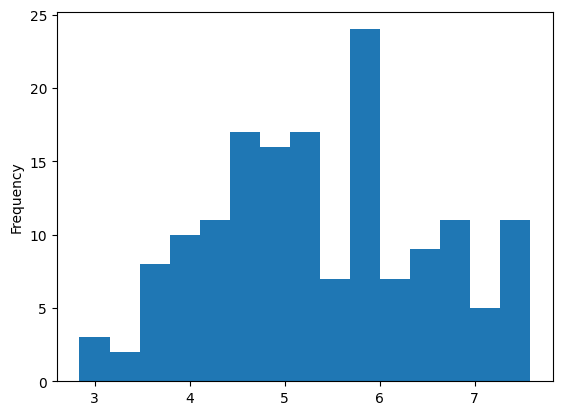

In [22]:
df_train['happiness_score'].plot.hist(bins=15)

In [100]:
train(prepare_data_2015,prepare_data_2015)

KeyError: "['country', 'region'] not in index"

0.8174997785535861

In [17]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse =mean_squared_error(y_test, y_pred, squared=False)

,Family,Health (Life Expectancy),Freedom
0,1.34951,0.94143,0.66557
1,1.40223,0.94784,0.62877
2,1.36058,0.87464,0.64938
3,1.33095,0.88521,0.66973
4,1.32261,0.90563,0.63297
...,...,...,...
153,0.77370,0.42864,0.59201
154,0.35386,0.31910,0.48450
155,0.47489,0.72193,0.15684
156,0.41587,0.22396,0.11850


In [14]:
df.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')